In [107]:
# PACKAGES

# Import the packages that will be used in this assignment the as term allows shorthand referencing of the modules.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import scipy.signal as signal
from scipy.signal import butter, filtfilt, find_peaks, savgol_filter, medfilt, iirnotch, cheby1

# Set the seaborn graph theme mainly this just makes my graphs look nice
sns.set_theme("paper", rc={'figure.figsize':(14,6.5), "grid.linewidth": 1.5}, palette="bright", font_scale=2)
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": "-", "axes.edgecolor": "black", "axes.linewidth": 1,"xtick.color": "black", "ytick.color": "black"})

# Set some default parameters to Matplotlib - again just to make graphs look nice
plt.rcParams['font.family'] = 'JetBrains Mono'
plt.rcParams['axes.labelpad'] = 8
plt.rcParams['axes.titlepad'] = 20    
plt.rcParams['lines.linewidth'] = 1.5

In [108]:
# DATA LOADING

# Load the data from the text file into a dataframe
ppg_data = pd.read_csv('PPG_Signal.txt', sep=" ", header=None)

# Label the first column of the dataframe as signal to allow for easier referencing later
ppg_data.columns = ["raw_signal"]

# Show the first 10 values to ensure correct data loading
ppg_data.head()

,raw_signal
0,70
1,70
2,70
3,70
4,70


In [109]:
#  VARIABLE DECLARATION

# Get the number of samples by reading the data frame
sample_count = len(ppg_data)

# Define sampling rate in samples per second
sampling_rate_hz = 75 

# Calculate the sampling time
sampling_time = sample_count/sampling_rate_hz

# Get the minimum and maximum values and mean values

min_signal = min(ppg_data['raw_signal'])

max_signal = max(ppg_data['raw_signal'])

mean_signal = statistics.mean(ppg_data['raw_signal'])

# Output values to verify assumptions
print(f"""
Sample Count: {sample_count}
Sampling Rate: {sampling_rate_hz} Hz
Sampling Time: {sampling_time} Seconds
Min Value: {min_signal}
Max Value: {max_signal}
Mean Value: {mean_signal}""")


Sample Count: 4500
Sampling Rate: 75 Hz
Sampling Time: 60.0 Seconds
Min Value: 63
Max Value: 179
Mean Value: 99.3968888888889


In [110]:
# TIMESCALE

# Create a time vector component by dividing the index of sample by the rate of sampling
time_scale = np.arange(sample_count) / sampling_rate_hz

# Add the time vector to the dataframe
ppg_data['time'] = time_scale

# Show the first 10 values to ensure correct data loading
ppg_data.head()


,raw_signal,time
0,70,0.000000
1,70,0.013333
2,70,0.026667
3,70,0.040000
4,70,0.053333


In [111]:
# DEMEAN SIGNAL

# Subtract the mean from each signal value to zero data
ppg_data['demeaned_signal'] = ppg_data['raw_signal'] - mean_signal;

In [ ]:
# FOURIER
# Create a DataFrame to store the frequency-domain data
ppg_frequency_data = pd.DataFrame()

# FFT of the raw signal
ppg_frequency_data['raw_signal_complex_component'] = np.fft.fft(ppg_data['raw_signal'])

# FFT of the demeaned signal
ppg_frequency_data['demeaned_signal'] = np.fft.fft(ppg_data['demeaned_signal'])

# Compute bins for the FFT output
ppg_frequency_data['frequency_spectrum'] = np.fft.fftfreq(sample_count, d=1/sampling_rate_hz)

# Mask to filter non-negative frequencies
frequency_mask = ppg_frequency_data['frequency_spectrum'] >= 0


In [113]:
# BANDPASS FILTER 

def butter_bandpass_filter(data, fs, lowcut, highcut, order):
    
    # Normalize frequencies to the Nyquist
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')

    # filtfilt applies the filter in forward and reverse directions to avoid phase shift
    filtered = filtfilt(b, a, data)

    return filtered

In [ ]:
# NOTCH FILTER
def notch_filter(signal, fs, notch_freq, Q):
    b, a = iirnotch(notch_freq, Q, fs)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

In [ ]:
# BANDPASS FILTER HEART RATE
#Declare lowcut threshold
lowcut_hr = 1.1  # ~66 BPM
#Declare highcut threshold
highcut_hr = 3   # ~180 BPM
#Run the Bandpass Filter
ppg_data['filtered_signal_heart'] = butter_bandpass_filter(ppg_data['demeaned_signal'], sampling_rate_hz, lowcut_hr, highcut_hr, 5)

# Notch Filter the 2.7 Hz artefact
ppg_data['notch_filtered_signal_heart'] = notch_filter(ppg_data['filtered_signal_heart'], 75, 2.7, 10)

In [116]:
# NOTCH FILTER HEART RATE
ppg_data['notch_filtered_signal_heart'] = notch_filter(ppg_data['filtered_signal_heart'], 75, 2.7, 10)

In [ ]:
# FILTER BREATHING

#Highpass
low_cut = 0.1 #  Hz
b_high, a_high = butter(N=2, Wn=low_cut/(75/2), btype='high')
ppg_data['highpass_signal_breath'] = filtfilt(b_high, a_high, ppg_data['demeaned_signal'])

#Savgol
window_length = 200
polyorder = 1
ppg_data['highpass_savgol'] = savgol_filter(ppg_data['highpass_signal_breath'], window_length, polyorder)

# BANDPASS
lowcut_hr = 0.15 
highcut_hr = 0.3 
ppg_data['filtered_signal_breath'] = butter_bandpass_filter(ppg_data['highpass_savgol'], sampling_rate_hz, lowcut_hr, highcut_hr, 2)

In [118]:
# Create a mask to filter the time range between 10s and 50s
time_mask = (ppg_data['time'] >= 10) & (ppg_data['time'] <= 50)

# Apply the mask to extract the subset of PPG data within the selected time range
ppg_data_ten_second_subset = ppg_data[time_mask].copy()

# Extract the time values for the selected subset
time_subset = ppg_data_ten_second_subset['time'].values

# Extract the filtered heart rate signal for the selected time subset
filtered_signal_heart_subset = ppg_data_ten_second_subset['notch_filtered_signal_heart'].values

# Extract the filtered breathing signal for the selected time subset
filtered_signal_breath_subset = ppg_data_ten_second_subset['filtered_signal_breath'].values


In [119]:
# Detect peaks in the heart signal within the specified subset
# Only peaks with a height greater than 15 are considered
heart_rate_peaks, _ = find_peaks(filtered_signal_heart_subset, height=15)

# Count the number of detected peaks (heartbeats)
num_peaks = len(heart_rate_peaks)

# Define the duration of the analyzed signal in seconds
duration_seconds = 40

# Convert the duration to minutes
duration_minutes = duration_seconds / 60.0

# Calculate the estimated heart rate in beats per minute (BPM)
breaths_per_minute = num_peaks / duration_minutes

# Print the results
print("Number of peaks (Heart Beats) between 10s and 50s:", num_peaks)
print("Duration (minutes):", duration_minutes)
print("Estimated heart rate (beats per minute):", breaths_per_minute)

Number of peaks (Heart Beats) between 10s and 50s: 45
Duration (minutes): 0.6666666666666666
Estimated heart rate (beats per minute): 67.5


In [ ]:
# Detect peaks in the filtered breathing signal within the selected time subset



Number of peaks (breaths) between 10s and 50s: 8
Duration (minutes): 0.6666666666666666
Estimated breathing rate (breaths per minute): 12.0


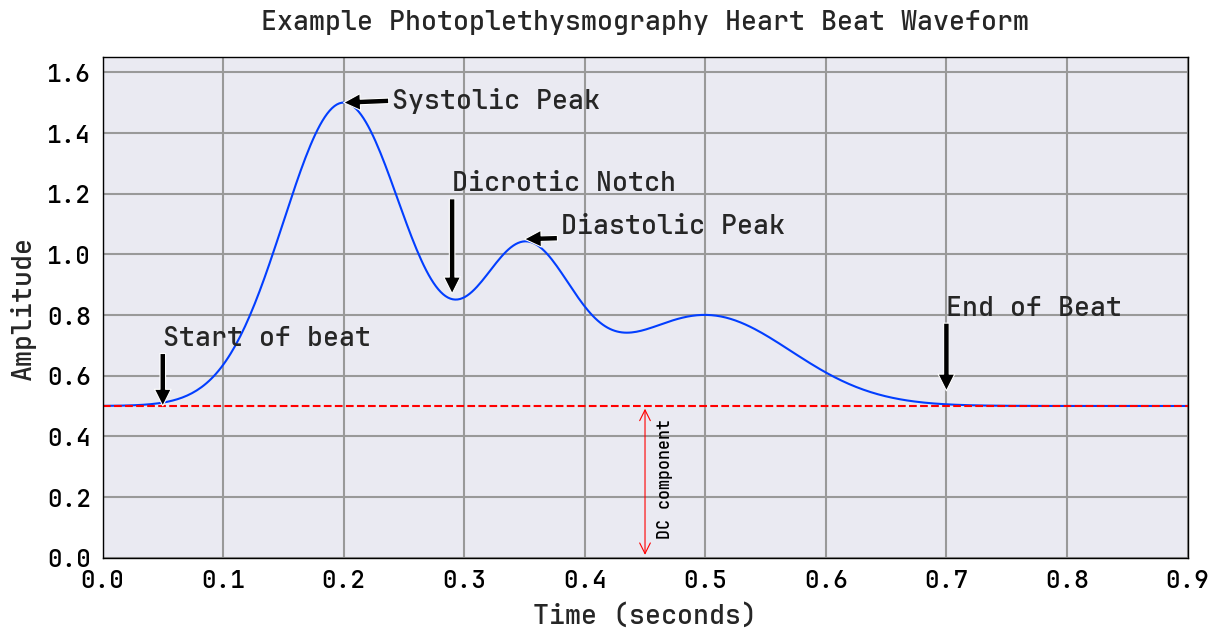

In [121]:
# Simulate a PPG waveform with DC offset using Gaussian peaks
t = np.linspace(0, 1, 500)
dc_offset = 0.5
waveform = (
    dc_offset +
    np.exp(-((t - 0.2) ** 2) / 0.005) +  # Systolic peak
    0.5 * np.exp(-((t - 0.35) ** 2) / 0.003) +  # Dicrotic notch
    0.3 * np.exp(-((t - 0.5) ** 2) / 0.01)  # Diastolic peak
)

# Plot the waveform
example_ppg_waveform = sns.lineplot(x=t, y= waveform)


# Annotations
example_ppg_waveform.annotate('Start of beat', xy=(0.05, 0.00 + dc_offset), xytext=(0.05, 0.2 + dc_offset),
             arrowprops=dict(facecolor='black', shrink=1.05))

example_ppg_waveform.annotate('Systolic Peak', xy=(0.2, 1.0 + dc_offset), xytext=(0.24, 0.98 + dc_offset),
             arrowprops=dict(facecolor='black', shrink=1.05))

example_ppg_waveform.annotate('Dicrotic Notch', xy=(0.29, 0.37 + dc_offset), xytext=(0.29, 0.71 + dc_offset),
             arrowprops=dict(facecolor='black', shrink=1.05))

example_ppg_waveform.annotate('Diastolic Peak', xy=(0.35, 0.55 + dc_offset), xytext=(0.38, 0.57 + dc_offset),
             arrowprops=dict(facecolor='black', shrink=1.05))

example_ppg_waveform.annotate('End of Beat', xy=(0.7, 0.05 + dc_offset), xytext=(0.7, 0.3 + dc_offset),
             arrowprops=dict(facecolor='black', shrink=1.05))

example_ppg_waveform.axhline(y=dc_offset, color='red', linestyle='--', label='DC Component')

example_ppg_waveform.annotate('', xy=(0.45, 0.5), xytext=(0.45, 0.0), arrowprops=dict(arrowstyle='<->', color='red'))

example_ppg_waveform.text(0.46, 0.26, 'DC component', va='center', rotation=90, color='black', fontsize=12)


# Edit the plot styling
example_ppg_waveform.set_xlabel('Time (seconds)')
example_ppg_waveform.set_ylabel('Amplitude')
example_ppg_waveform.set_title('Example Photoplethysmography Heart Beat Waveform')
example_ppg_waveform.set_ylim(0, 1.15 + dc_offset)
example_ppg_waveform.set_xlim(-0.0, 0.9)

# Save the Figure
figure_21 = example_ppg_waveform.get_figure()
figure_21.savefig('figure_21.png')

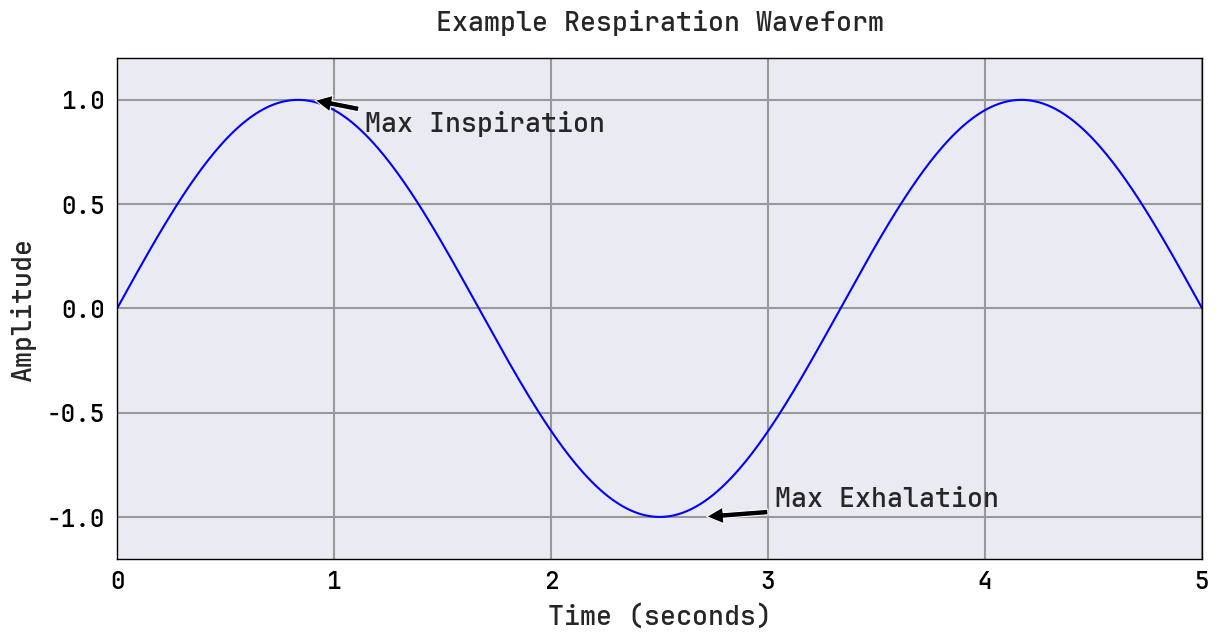

In [160]:
# Simulate a respiration waveform using sinusoidal function
t = np.linspace(0, 5, 500)
respiration_waveform = np.sin(3 * np.pi * 0.2 * t)  # 0.2 Hz ~ 12 breaths per minute

# Plot the respiration waveform
example_breathing_waveform = sns.lineplot(x=t, y=respiration_waveform, color='blue')

# Annotations for inspiration and exhalation
example_breathing_waveform.annotate('Max Inspiration', xy=(0.9, 1), xytext=(1.14, 0.85),
             arrowprops=dict(facecolor='black', shrink=0.05))

example_breathing_waveform.annotate('Max Exhalation', xy=(2.7, -1.0), xytext=(3.03, -0.95),
             arrowprops=dict(facecolor='black', shrink=0.05))

# Clean up the plot aesthetics
example_breathing_waveform.set_xlabel('Time (seconds)')
example_breathing_waveform.set_ylabel('Amplitude')
example_breathing_waveform.set_title('Example Respiration Waveform')

example_breathing_waveform.set_ylim(-1.2, 1.2)
example_breathing_waveform.set_xlim(0, 5)

figure_400 = example_breathing_waveform.get_figure()
figure_400.savefig('breathingrategraph.png')

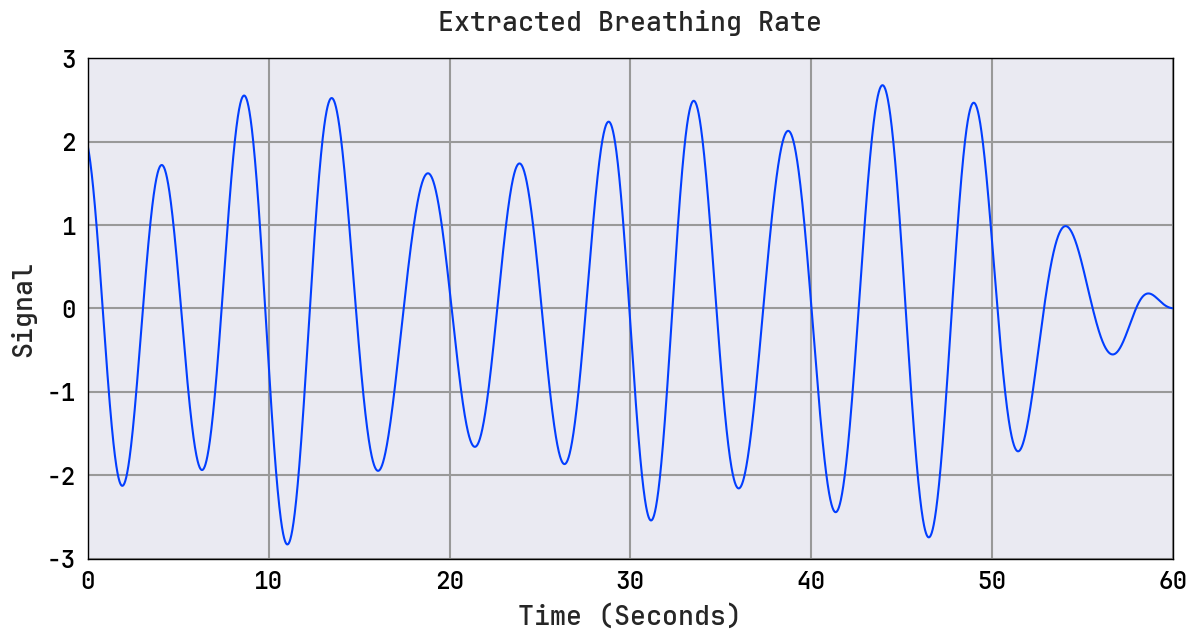

In [123]:
# GRAPH 11

# Plot the extracted breathing rate signal over time
Breathing_Rate_plot = sns.lineplot(x=ppg_data['time'], y=ppg_data['filtered_signal_breath'])

# Set the x-axis and y-axis limits based on the expected signal range
Breathing_Rate_plot.set_xlim(0, 60)
Breathing_Rate_plot.set_ylim(-3, 3)

# Label the x-axis and y-axis
Breathing_Rate_plot.set_xlabel("Time (Seconds)")
Breathing_Rate_plot.set_ylabel("Signal")

# Set the title for the graph
Breathing_Rate_plot.set_title("Extracted Breathing Rate")


# Save the figure as an image file
figure_11 = Breathing_Rate_plot.get_figure()
figure_11.savefig('graph_11.png')


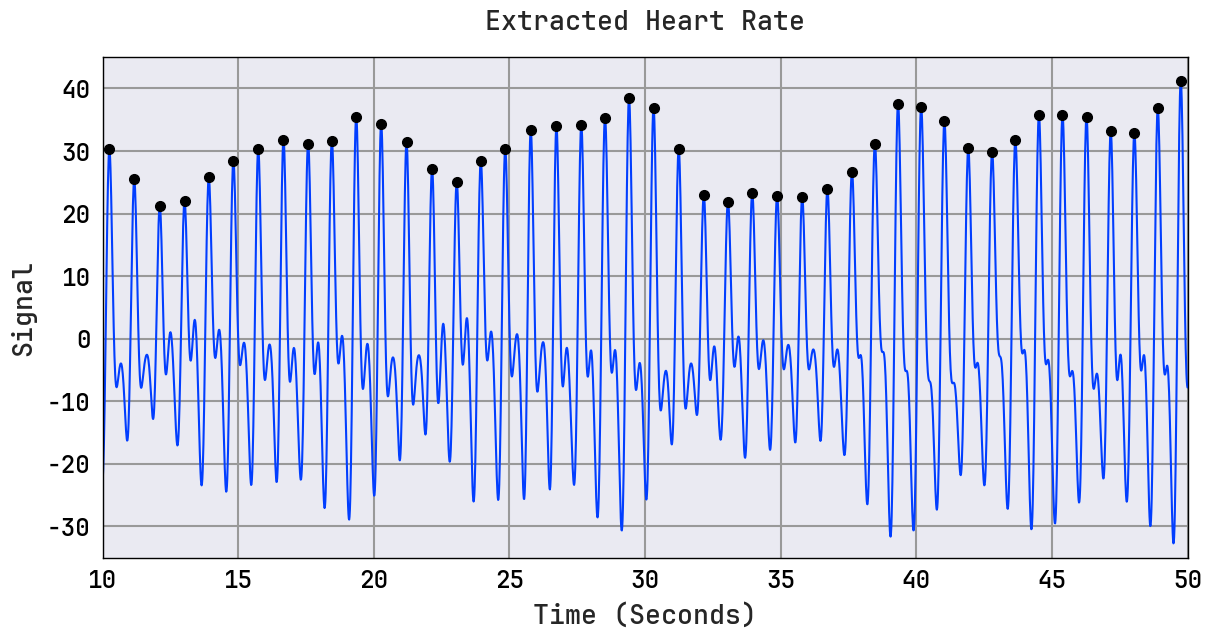

In [124]:
# GRAPH 12

# Plot the extracted heart rate signal over time for the selected subset
heart_rate_peaks_plot = sns.lineplot(x=time_subset, y=filtered_signal_heart_subset)

# Set the x-axis and y-axis limits based on the selected time window and signal range
heart_rate_peaks_plot.set_xlim(10, 50)
heart_rate_peaks_plot.set_ylim(-35, 45)

# Label the x-axis and y-axis
heart_rate_peaks_plot.set_xlabel("Time (Seconds)")
heart_rate_peaks_plot.set_ylabel("Signal")

# Set the title for the graph
heart_rate_peaks_plot.set_title("Extracted Heart Rate")

# Plot detected heart rate peaks on the graph as black circles
heart_rate_peaks_plot.plot(time_subset[heart_rate_peaks], filtered_signal_heart_subset[heart_rate_peaks], 'o', markersize=7, color='black')

# Save the figure as an image file
figure_12 = heart_rate_peaks_plot.get_figure()
figure_12.savefig('graph_12.png')


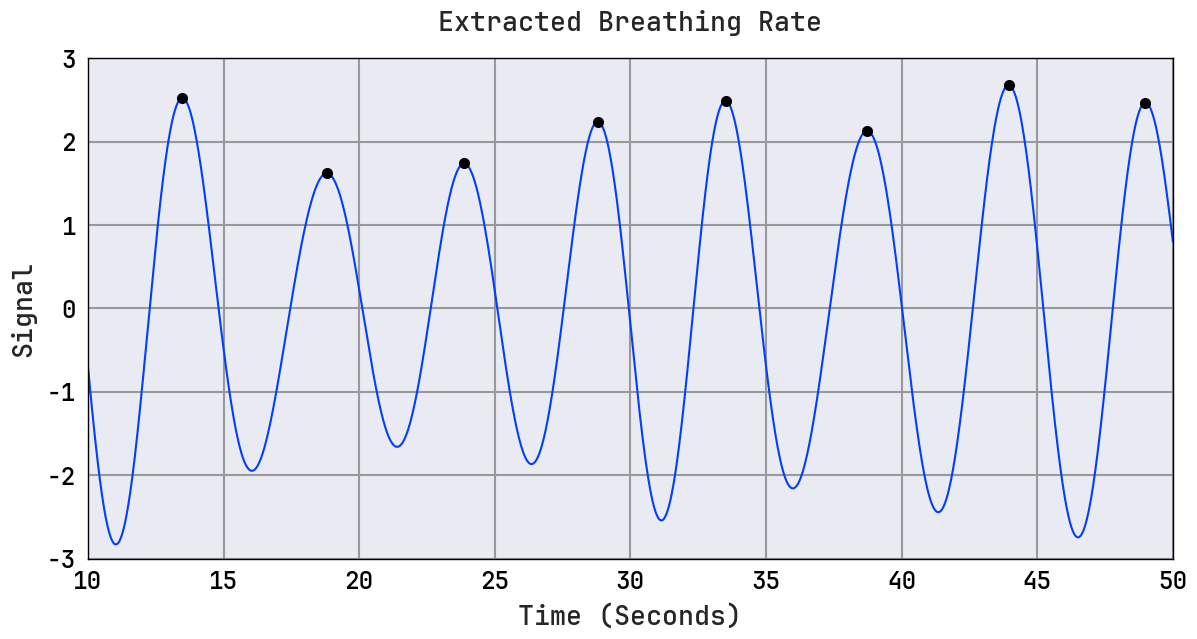

In [125]:
# GRAPH 13

# Plot the extracted breathing rate signal over time for the selected subset
breathing_rate_plot_ten_seconds = sns.lineplot(x=time_subset, y=ppg_data_ten_second_subset['filtered_signal_breath'])

# Set the x-axis and y-axis limits based on the selected time window and signal range
breathing_rate_plot_ten_seconds.set_xlim(10, 50)
breathing_rate_plot_ten_seconds.set_ylim(-3, 3)

# Label the x-axis and y-axis
breathing_rate_plot_ten_seconds.set_xlabel("Time (Seconds)")
breathing_rate_plot_ten_seconds.set_ylabel("Signal")

# Set the title for the graph
breathing_rate_plot_ten_seconds.set_title("Extracted Breathing Rate")

# Plot detected breathing rate peaks on the graph as black circles
breathing_rate_plot_ten_seconds.plot(time_subset[breathing_peaks], filtered_signal_breath_subset[breathing_peaks], 
                                     'o', markersize=7, color='black')

# Save the figure as an image file
figure_13 = breathing_rate_plot_ten_seconds.get_figure()
figure_13.savefig('graph_13.png')


C:\Users\SamMc\AppData\Local\Temp\ipykernel_14568\832410995.py:28: RuntimeWarning: divide by zero encountered in log10
  axes[0].plot(w1, 20 * np.log10(abs(h1)), label='2nd Order (0.15 - 0.3 Hz)', color='blue')
C:\Users\SamMc\AppData\Local\Temp\ipykernel_14568\832410995.py:41: RuntimeWarning: divide by zero encountered in log10
  axes[1].plot(w2, 20 * np.log10(abs(h2)), label='5th Order (1.1 - 3 Hz)', color='green')


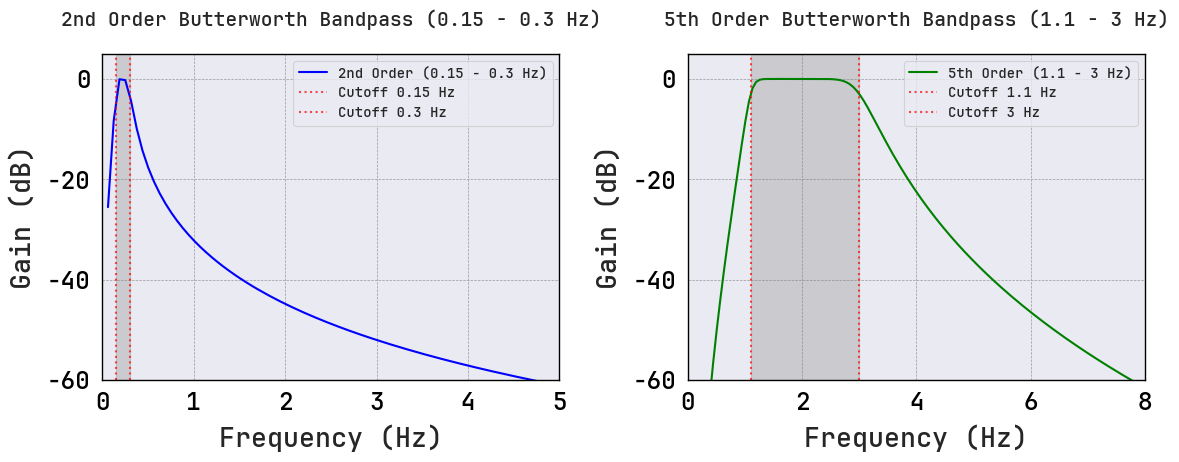

In [126]:
# BANDPASS FILTER GRAPH

# Define the sampling frequency
fs = 75  # 75 Hz sampling frequency

# Define the frequency range for plotting the frequency response
freqs = np.logspace(-2, 2, 1000)  # Logarithmic spacing from 0.01 Hz to 100 Hz

# Design the first Butterworth bandpass filter (2nd order, 0.15 to 0.3 Hz)
low1, high1 = 0.15 / (fs / 2), 0.3 / (fs / 2)  # Normalize frequencies
b1, a1 = signal.butter(2, [low1, high1], btype='bandpass', analog=False)

# Design the second Butterworth bandpass filter (5th order, 1.1 to 3 Hz)
low2, high2 = 1.1 / (fs / 2), 3 / (fs / 2)  # Normalize frequencies
b2, a2 = signal.butter(5, [low2, high2], btype='bandpass', analog=False)

# Define the frequency range for plotting
freqs = np.linspace(0, 10, 1000)  # Linear spacing from 0 to 10 Hz

# Compute frequency responses
w1, h1 = signal.freqz(b1, a1, worN=2 * np.pi * freqs, fs=fs)
w2, h2 = signal.freqz(b2, a2, worN=2 * np.pi * freqs, fs=fs)

# Create side-by-side plots for each filter
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the first filter (0.15 - 0.3 Hz, 2nd order)
axes[0].plot(w1, 20 * np.log10(abs(h1)), label='2nd Order (0.15 - 0.3 Hz)', color='blue')
axes[0].axvline(0.15, color='red', linestyle=':', alpha=0.7, label="Cutoff 0.15 Hz")
axes[0].axvline(0.3, color='red', linestyle=':', alpha=0.7, label="Cutoff 0.3 Hz")
axes[0].axvspan(0.15, 0.3, color='grey', alpha=0.3)
axes[0].set_xlabel('Frequency (Hz)')
axes[0].set_ylabel('Gain (dB)')
axes[0].set_title('2nd Order Butterworth Bandpass (0.15 - 0.3 Hz)', fontsize=14)
axes[0].grid(True, linestyle='--', linewidth=0.5)
axes[0].set_ylim(-60, 5)
axes[0].set_xlim(0, 5)
axes[0].legend(fontsize=10)

# Plot the second filter (1.1 - 3 Hz, 5th order)
axes[1].plot(w2, 20 * np.log10(abs(h2)), label='5th Order (1.1 - 3 Hz)', color='green')
axes[1].axvline(1.1, color='red', linestyle=':', alpha=0.7, label="Cutoff 1.1 Hz")
axes[1].axvline(3, color='red', linestyle=':', alpha=0.7, label="Cutoff 3 Hz")
axes[1].axvspan(1.1, 3, color='grey', alpha=0.3)
axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_ylabel('Gain (dB)')
axes[1].set_title('5th Order Butterworth Bandpass (1.1 - 3 Hz)', fontsize=14)
axes[1].grid(True, linestyle='--', linewidth=0.5)
axes[1].set_ylim(-60, 5)
axes[1].set_xlim(0, 8)
axes[1].legend(fontsize=10)

plt.tight_layout()
fig.savefig('bandpass_plot')

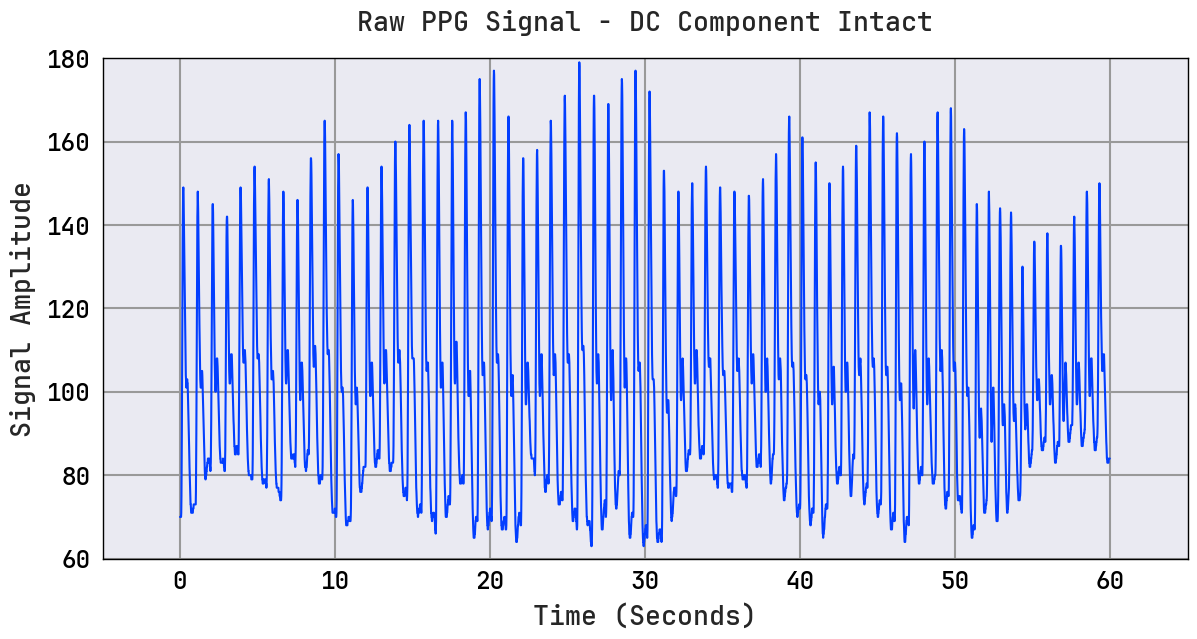

In [127]:
# GRAPH_1

# Plot the data on a line graph specifying x and y values from the data above.
raw_signal_plot = sns.lineplot(x=ppg_data['time'], y=ppg_data['raw_signal'])

# Set the x axis and y axis limits - these are defined manually by previous plotting 
raw_signal_plot.set_xlim(-5, 65)
raw_signal_plot.set_ylim(60,180)

# Set the x axis and y axis labels
raw_signal_plot.set_xlabel("Time (Seconds)")
raw_signal_plot.set_ylabel("Signal Amplitude")

# Set the title for the graph
raw_signal_plot.set_title("Raw PPG Signal - DC Component Intact")

# Save the Figure
figure_1 = raw_signal_plot.get_figure()
figure_1.savefig('graph_1.png')

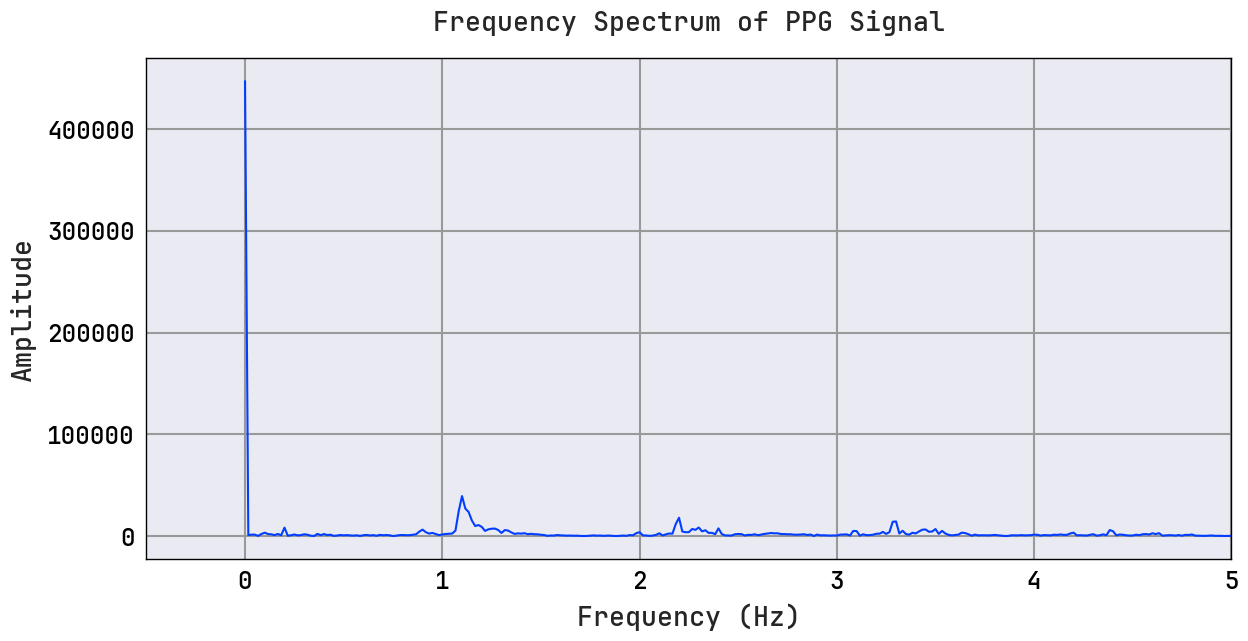

In [128]:
# GRAPH 2

# Plot the frequency spectrum of the PPG signal using a line graph
frequency_plot = sns.lineplot(x=ppg_frequency_data['frequency_spectrum'][frequency_mask], y=abs(ppg_frequency_data['raw_signal_complex_component'][frequency_mask]))

# Label the x-axis and y-axis
frequency_plot.set_xlabel('Frequency (Hz)')
frequency_plot.set_ylabel('Amplitude')

# Set the title for the graph
frequency_plot.set_title('Frequency Spectrum of PPG Signal')

# Set the x-axis limits to focus on the relevant frequency range
frequency_plot.set_xlim(-0.5, 5)

# Save the figure as an image file
figure_2 = frequency_plot.get_figure()
figure_2.savefig("graph_2.png")

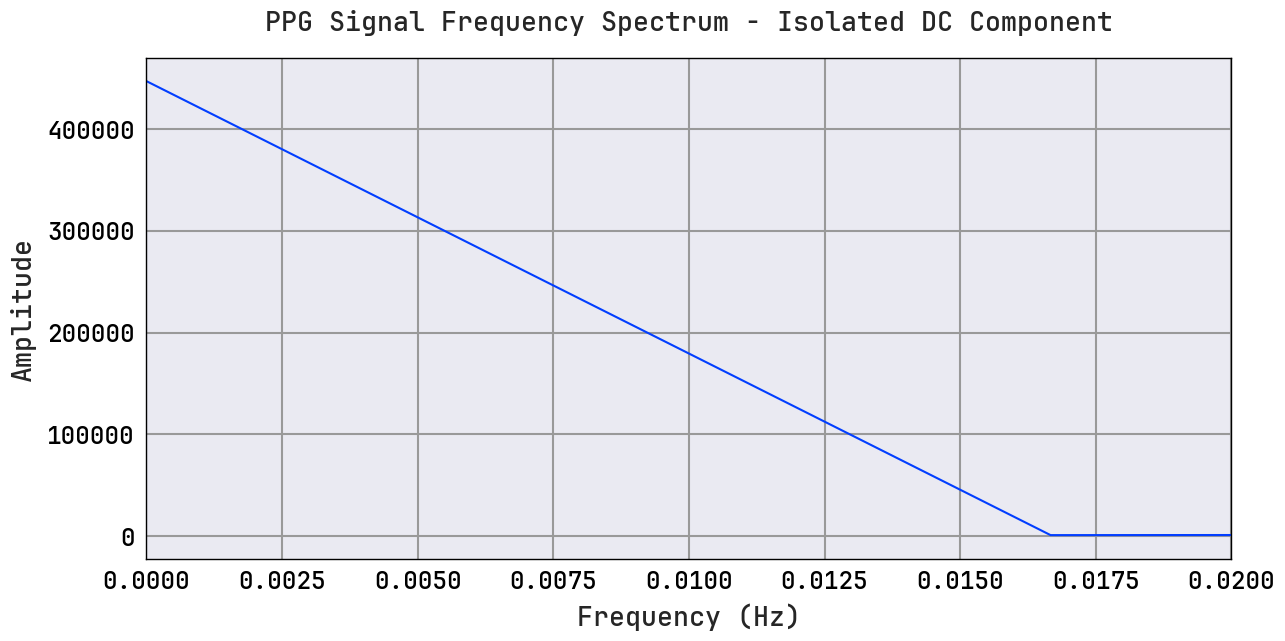

In [129]:
# GRAPH 3

# Plot the isolated DC component of the PPG signal in the frequency domain
DC_Component = sns.lineplot(x=ppg_frequency_data['frequency_spectrum'][frequency_mask], y=abs(ppg_frequency_data['raw_signal_complex_component'][frequency_mask]))

# Label the x-axis and y-axis
DC_Component.set_xlabel('Frequency (Hz)')
DC_Component.set_ylabel('Amplitude')

# Set the title for the graph
DC_Component.set_title('PPG Signal Frequency Spectrum - Isolated DC Component')

# Set the x-axis limits to focus on the very low-frequency range where the DC component is present
DC_Component.set_xlim(0, 0.02)

# Save the figure as an image file
figure_3 = DC_Component.get_figure()
figure_3.savefig('graph_3.png')

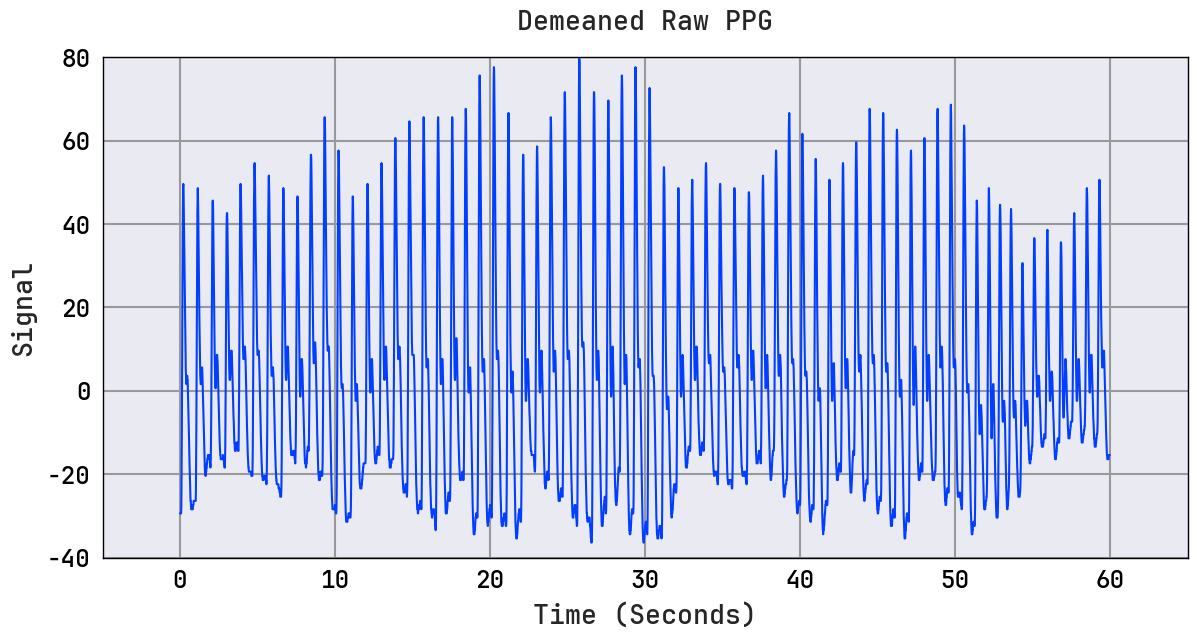

In [130]:
# GRAPH 4

# Plot the demeaned PPG signal over time
demeaned_signal_plot = sns.lineplot(x=ppg_data['time'], y=ppg_data['demeaned_signal'])

# Set the x-axis and y-axis limits based on the expected signal range
demeaned_signal_plot.set_xlim(-5, 65)
demeaned_signal_plot.set_ylim(-40, 80)

# Label the x-axis and y-axis
demeaned_signal_plot.set_xlabel("Time (Seconds)")
demeaned_signal_plot.set_ylabel("Signal")

# Set the title for the graph
demeaned_signal_plot.set_title("Demeaned Raw PPG")

# Save the figure as an image file
figure_4 = demeaned_signal_plot.get_figure()
figure_4.savefig('graph_4.png')

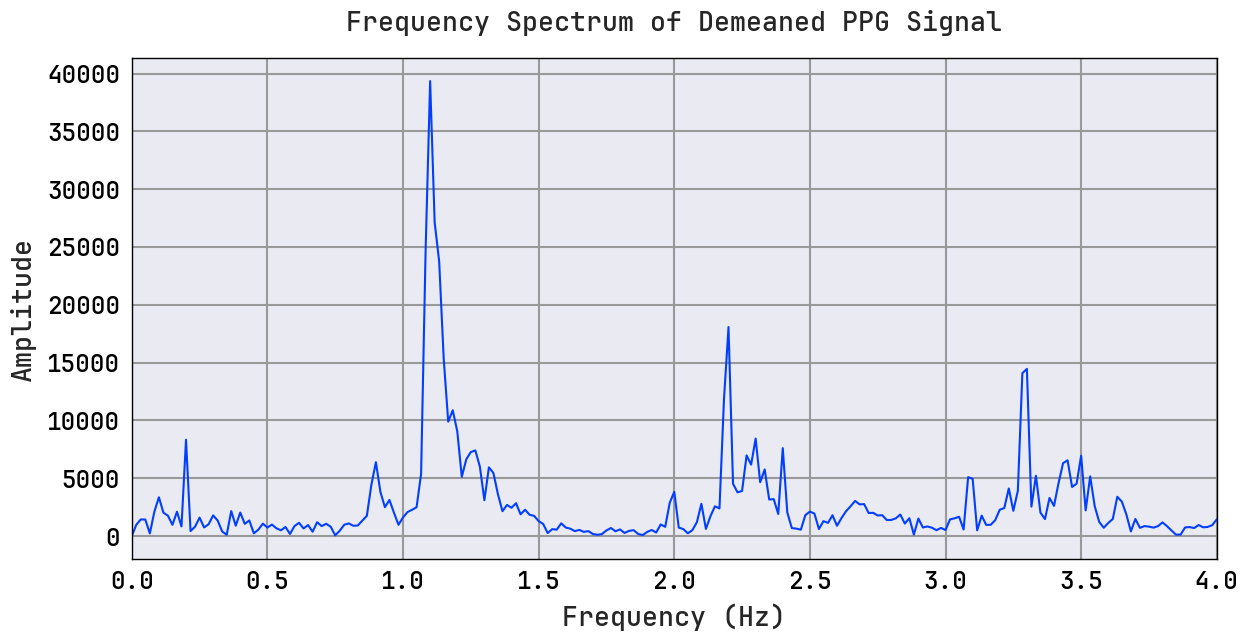

In [131]:
# GRAPH 5

# Plot the frequency spectrum of the demeaned PPG signal
demeaned_frequency_plot = sns.lineplot(x=ppg_frequency_data['frequency_spectrum'][frequency_mask], y=abs(ppg_frequency_data['demeaned_signal'][frequency_mask]))

# Label the x-axis and y-axis
demeaned_frequency_plot.set_xlabel('Frequency (Hz)')
demeaned_frequency_plot.set_ylabel('Amplitude')

# Set the title for the graph
demeaned_frequency_plot.set_title('Frequency Spectrum of Demeaned PPG Signal')

# Set the x-axis limit to focus on the relevant frequency range
demeaned_frequency_plot.set_xlim(0, 4)

# Save the figure as an image file
figure_5 = demeaned_frequency_plot.get_figure()
figure_5.savefig('graph_5.png')

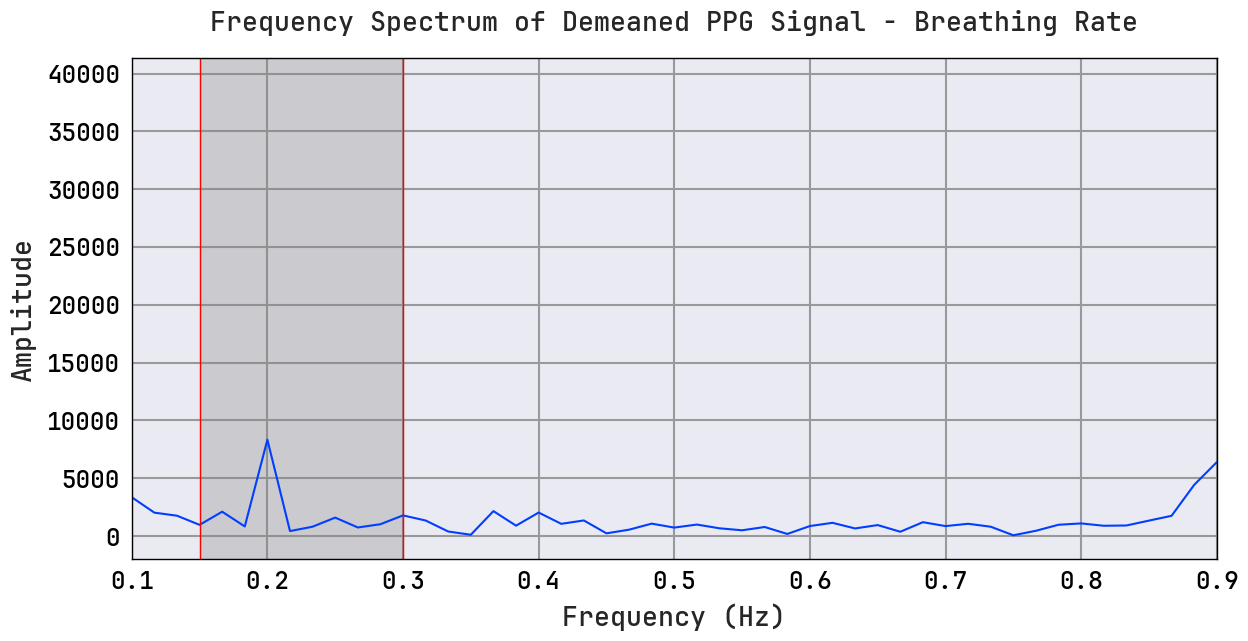

In [132]:
# GRAPH 6

# Plot the frequency spectrum of the demeaned PPG signal with breathing rate visualization
breathing_frequency_plot = sns.lineplot(x=ppg_frequency_data['frequency_spectrum'][frequency_mask], y=abs(ppg_frequency_data['demeaned_signal'][frequency_mask]))

# Label the x-axis and y-axis
breathing_frequency_plot.set_xlabel('Frequency (Hz)')
breathing_frequency_plot.set_ylabel('Amplitude')

# Set the title for the graph
breathing_frequency_plot.set_title('Frequency Spectrum of Demeaned PPG Signal - Breathing Rate')

# Set the x-axis limit to focus on the breathing frequency range
breathing_frequency_plot.set_xlim(0.10, 0.9)

# Highlight the expected breathing frequency range (0.15 Hz to 0.3 Hz)
plt.axvspan(0.15, 0.3, color='grey', alpha=0.3)

# Add vertical reference lines at 0.15 Hz and 0.3 Hz
plt.axvline(x=0.15, color='red', linestyle='-', linewidth=1)
plt.axvline(x=0.3, color='red', linestyle='-', linewidth=1)

# Save the figure as an image file
figure_6 = breathing_frequency_plot.get_figure()
figure_6.savefig('graph_6.png')

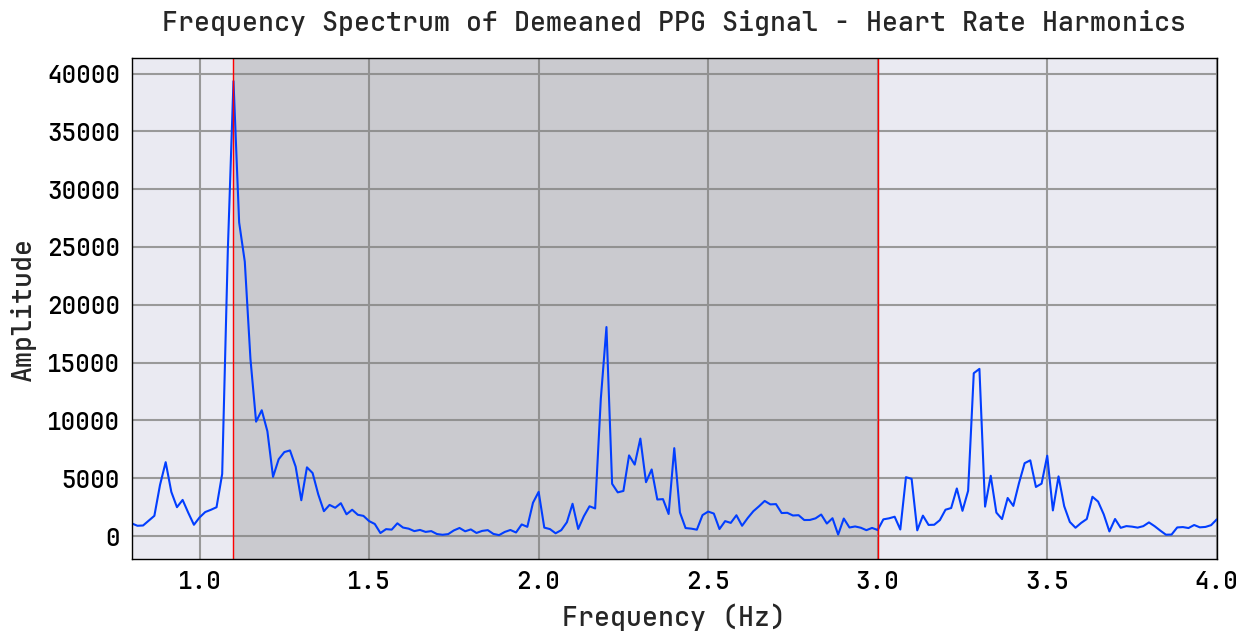

In [133]:
# GRAPH 7

# Plot the frequency spectrum of the demeaned PPG signal with heart rate harmonics visualization
heart_frequency_plot = sns.lineplot(x=ppg_frequency_data['frequency_spectrum'][frequency_mask], y=abs(ppg_frequency_data['demeaned_signal'][frequency_mask]))

# Label the x-axis and y-axis
heart_frequency_plot.set_xlabel('Frequency (Hz)')
heart_frequency_plot.set_ylabel('Amplitude')

# Set the title for the graph
heart_frequency_plot.set_title('Frequency Spectrum of Demeaned PPG Signal - Heart Rate Harmonics')

# Set the x-axis limit to focus on the heart rate frequency range
heart_frequency_plot.set_xlim(0.8, 4)

# Highlight the expected heart rate harmonics range (1.1 Hz to 3 Hz)
plt.axvspan(1.1, 3, color='grey', alpha=0.3)

# Add vertical reference lines at 1.1 Hz and 3 Hz
plt.axvline(x=1.1, color='red', linestyle='-', linewidth=1)
plt.axvline(x=3, color='red', linestyle='-', linewidth=1)

# Save the figure as an image file
figure_7 = heart_frequency_plot.get_figure()
figure_7.savefig('graph_7.png')

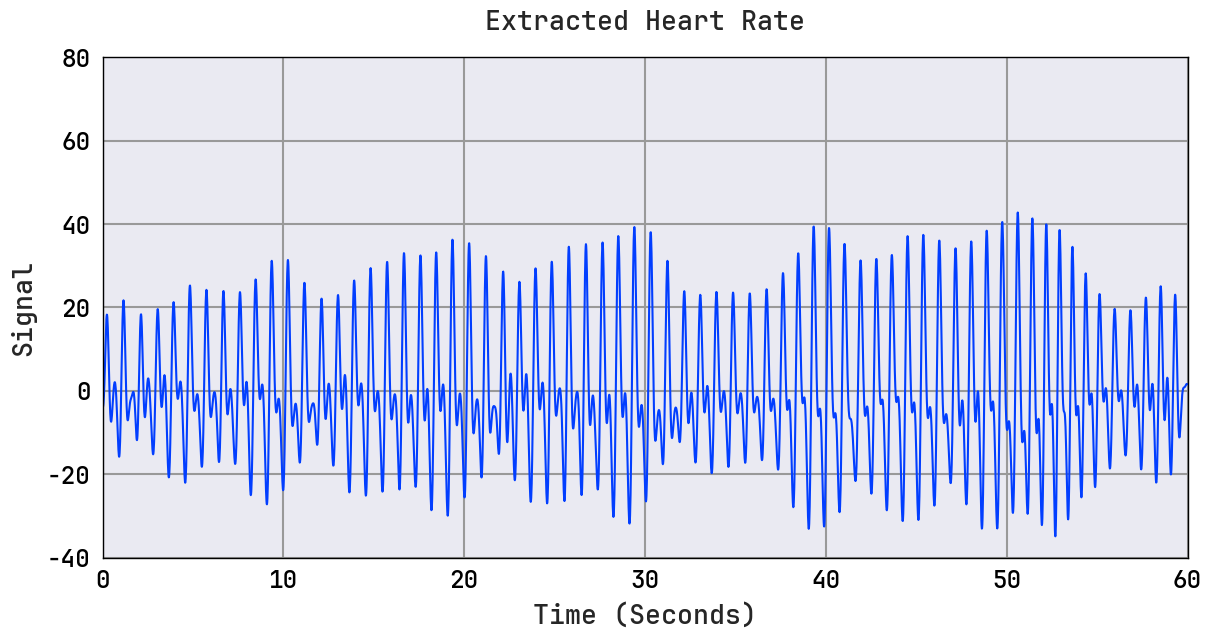

In [134]:
# GRAPH 8

# Plot the extracted heart rate signal over time
heart_rate_plot = sns.lineplot(x=ppg_data['time'], y=ppg_data['filtered_signal_heart'])

# Set the x-axis and y-axis limits based on the expected signal range
heart_rate_plot.set_xlim(0, 60)
heart_rate_plot.set_ylim(-40, 80)

# Label the x-axis and y-axis
heart_rate_plot.set_xlabel("Time (Seconds)")
heart_rate_plot.set_ylabel("Signal")

# Set the title for the graph
heart_rate_plot.set_title("Extracted Heart Rate")

# Save the figure as an image file
figure_8 = heart_rate_plot.get_figure()
figure_8.savefig('graph_8.png')

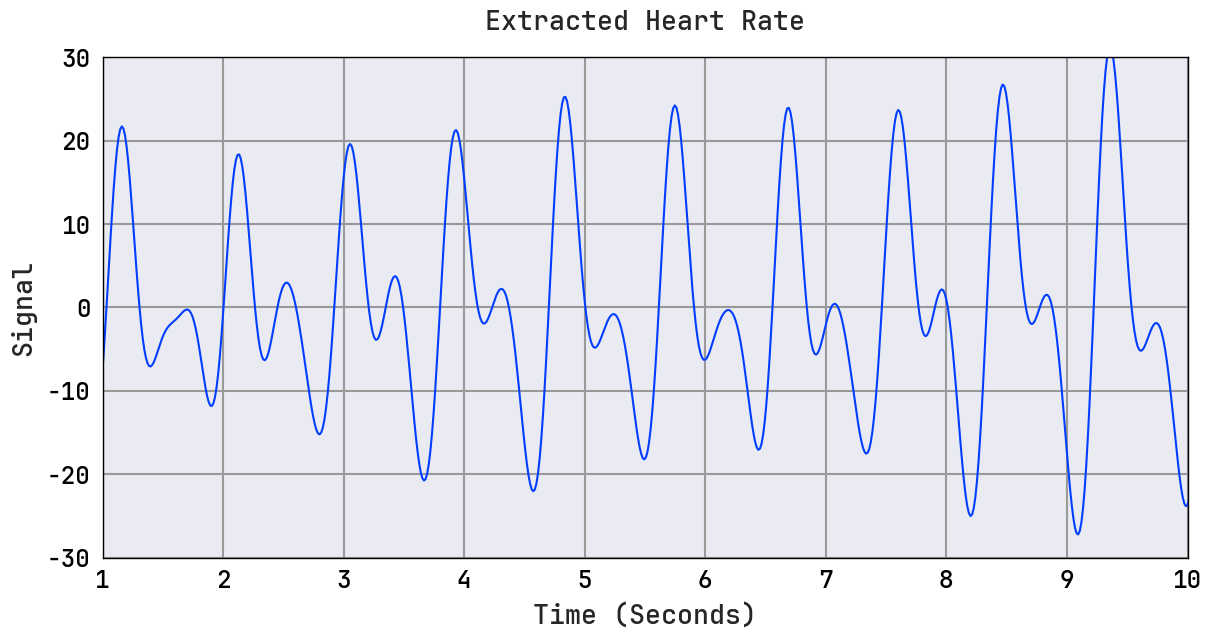

In [135]:
# GRAPH 9

# Plot the extracted heart rate signal over a 10-second window
heart_rate_plot_10_seconds = sns.lineplot(x=ppg_data['time'], y=ppg_data['filtered_signal_heart'])

# Set the x-axis and y-axis limits based on the selected time window and signal range
heart_rate_plot_10_seconds.set_xlim(1, 10)
heart_rate_plot_10_seconds.set_ylim(-30, 30)

# Label the x-axis and y-axis
heart_rate_plot_10_seconds.set_xlabel("Time (Seconds)")
heart_rate_plot_10_seconds.set_ylabel("Signal")

# Set the title for the graph
heart_rate_plot_10_seconds.set_title("Extracted Heart Rate")

# Save the figure as an image file
figure_9 = heart_rate_plot_10_seconds.get_figure()
figure_9.savefig('graph_9.png')


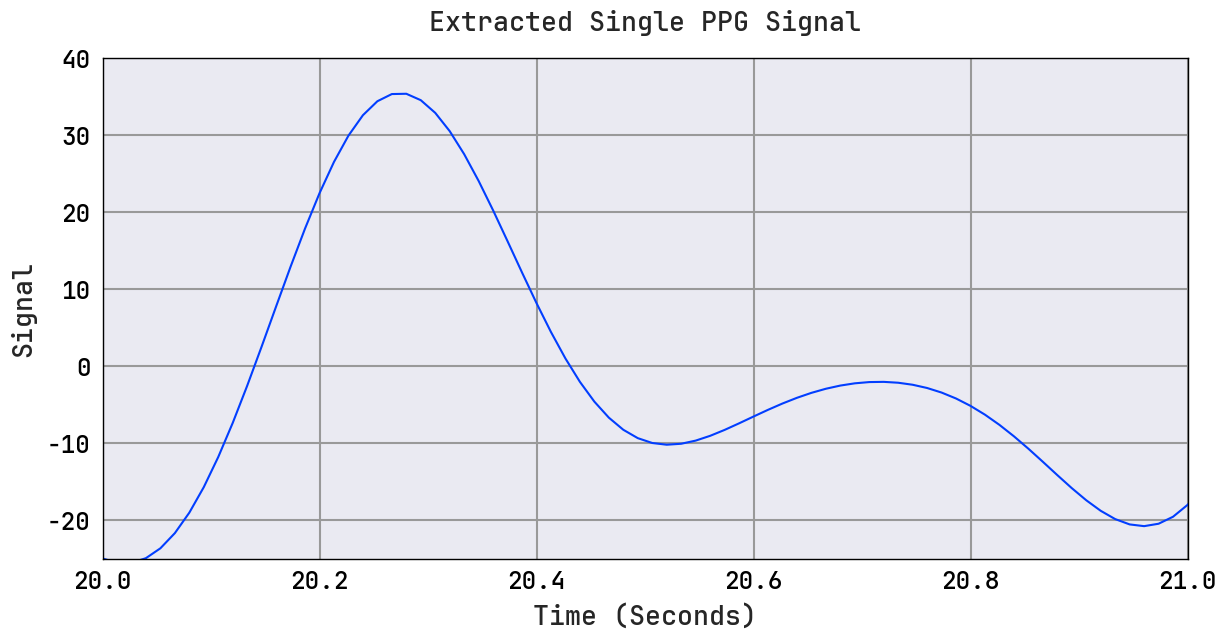

In [136]:
# GRAPH 10

# Plot the extracted heart rate signal for a single heartbeat cycle
heart_rate_plot_single_beat = sns.lineplot(x=ppg_data['time'], y=ppg_data['filtered_signal_heart'])

# Set the x-axis and y-axis limits to zoom in on a single heartbeat (1-second window)
heart_rate_plot_single_beat.set_xlim(20, 21)
heart_rate_plot_single_beat.set_ylim(-25, 40)

# Label the x-axis and y-axis
heart_rate_plot_single_beat.set_xlabel("Time (Seconds)")
heart_rate_plot_single_beat.set_ylabel("Signal")

# Set the title for the graph
heart_rate_plot_single_beat.set_title("Extracted Single PPG Signal")

# Save the figure as an image file
figure_10 = heart_rate_plot_single_beat.get_figure()
figure_10.savefig('graph_10.png')


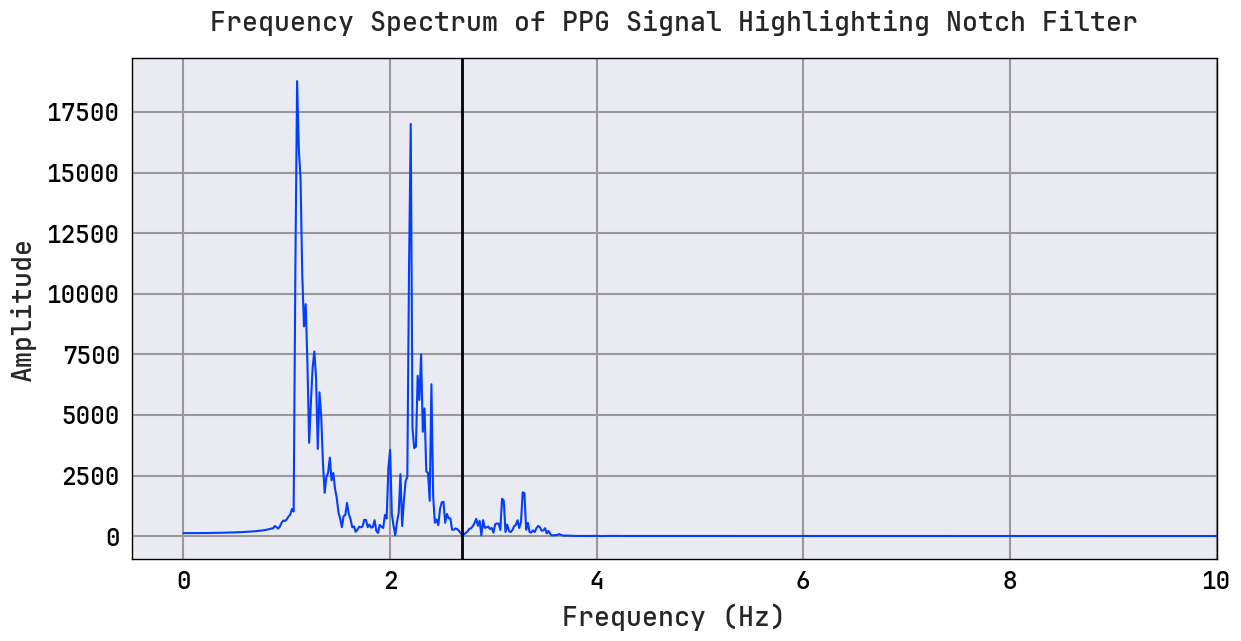

In [ ]:
# GRAPH 22

# Get Frequency Data Once Filtered
ppg_frequency_data['notch_filtered_heart_signal'] = np.fft.fft(ppg_data['notch_filtered_signal_heart'])

# Plot the frequency spectrum of the PPG signal after notch filtering
frequency_plot = sns.lineplot(x=ppg_frequency_data['frequency_spectrum'][frequency_mask], y=abs(ppg_frequency_data['notch_filtered_heart_signal'][frequency_mask]))

# Label the x-axis and y-axis
frequency_plot.set_xlabel('Frequency (Hz)')
frequency_plot.set_ylabel('Amplitude')

# Set the title for the graph
frequency_plot.set_title('Frequency Spectrum of PPG Signal Highlighting Notch Filter')

# Add a vertical line at 2.7 Hz to highlight the notch filter effect
frequency_plot.axvline(x=2.7, color='black', linestyle='-', linewidth=2)

# Set the x-axis limit to focus on the relevant frequency range
frequency_plot.set_xlim(-0.5, 10)

# Save the figure as an image file
figure_22 = frequency_plot.get_figure()
figure_22.savefig("graph_22.png")


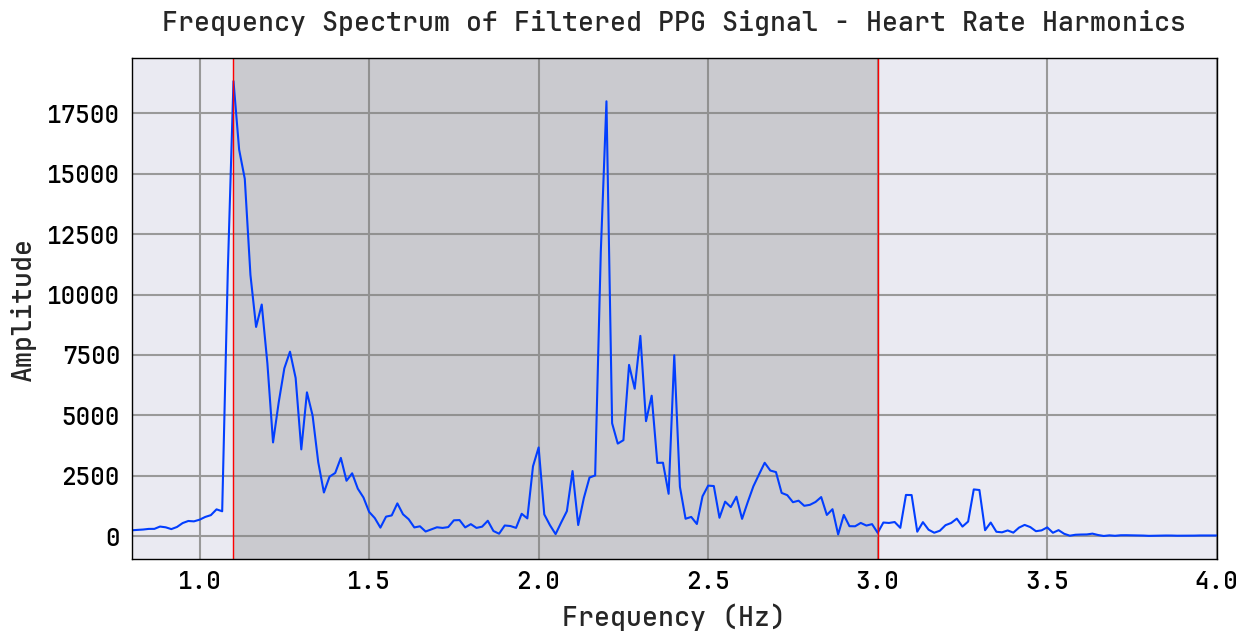

In [138]:
# GRAPH 30

# Compute the frequency spectrum of the filtered PPG signal for heart rate analysis
ppg_frequency_data['filtered_signal_heart'] = np.fft.fft(ppg_data['filtered_signal_heart'])

# Plot the frequency spectrum of the filtered PPG signal with heart rate harmonics visualization
heart_filtered_frequency_plot = sns.lineplot(x=ppg_frequency_data['frequency_spectrum'][frequency_mask], 
                                             y=abs(ppg_frequency_data['filtered_signal_heart'][frequency_mask]))

# Label the x-axis and y-axis
heart_filtered_frequency_plot.set_xlabel('Frequency (Hz)')
heart_filtered_frequency_plot.set_ylabel('Amplitude')

# Set the title for the graph
heart_filtered_frequency_plot.set_title('Frequency Spectrum of Filtered PPG Signal - Heart Rate Harmonics')

# Set the x-axis limit to focus on the heart rate frequency range
heart_filtered_frequency_plot.set_xlim(0.8, 4)

# Highlight the expected heart rate harmonics range (1.1 Hz to 3 Hz)
heart_filtered_frequency_plot.axvspan(1.1, 3, color='grey', alpha=0.3)

# Add vertical reference lines at 1.1 Hz and 3 Hz
heart_filtered_frequency_plot.axvline(x=1.1, color='red', linestyle='-', linewidth=1)
heart_filtered_frequency_plot.axvline(x=3, color='red', linestyle='-', linewidth=1)

# Save the figure as an image file
figure_30 = heart_filtered_frequency_plot.get_figure()
figure_30.savefig('graph_30.png')


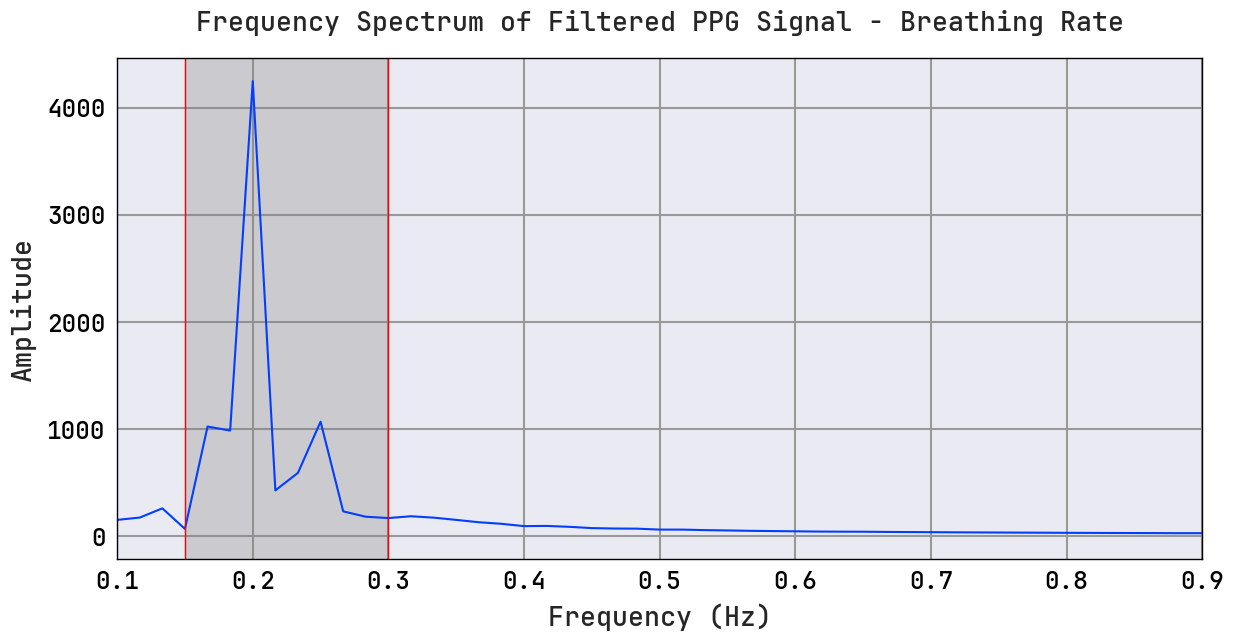

In [139]:
# GRAPH 31

# Compute the frequency spectrum of the filtered PPG signal for breathing rate analysis
ppg_frequency_data['filtered_signal_breath'] = np.fft.fft(ppg_data['filtered_signal_breath'])

# Plot the frequency spectrum of the filtered PPG signal with breathing rate visualization
breathing_frequency_plot_filtered = sns.lineplot(x=ppg_frequency_data['frequency_spectrum'][frequency_mask], 
                                                 y=abs(ppg_frequency_data['filtered_signal_breath'][frequency_mask]))

# Label the x-axis and y-axis
breathing_frequency_plot_filtered.set_xlabel('Frequency (Hz)')
breathing_frequency_plot_filtered.set_ylabel('Amplitude')

# Set the title for the graph
breathing_frequency_plot_filtered.set_title('Frequency Spectrum of Filtered PPG Signal - Breathing Rate')

# Set the x-axis limit to focus on the breathing frequency range
breathing_frequency_plot_filtered.set_xlim(0.10, 0.9)

# Highlight the expected breathing frequency range (0.15 Hz to 0.3 Hz)
breathing_frequency_plot_filtered.axvspan(0.15, 0.3, color='grey', alpha=0.3)

# Add vertical reference lines at 0.15 Hz and 0.3 Hz
breathing_frequency_plot_filtered.axvline(x=0.15, color='red', linestyle='-', linewidth=1)
breathing_frequency_plot_filtered.axvline(x=0.3, color='red', linestyle='-', linewidth=1)

# Save the figure as an image file
figure_31 = breathing_frequency_plot_filtered.get_figure()
figure_31.savefig('graph_31.png')


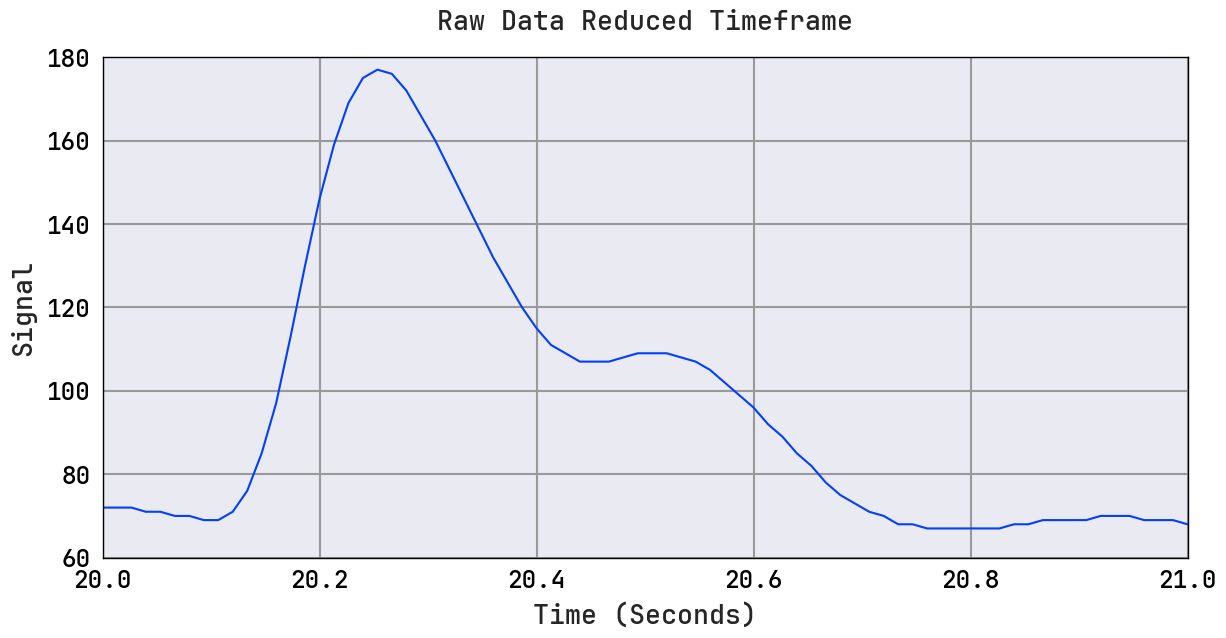

In [140]:
# GRAPH 101

# Plot the data on a line graph specifying x and y values from the data above.
single_beat_raw = sns.lineplot(x=ppg_data['time'], y=ppg_data['raw_signal'])

# Set the x axis and y axis limits - these are defined manually by previous plotting 
single_beat_raw.set_xlim(20, 21)
single_beat_raw.set_ylim(60,180)

# Set the x axis and y axis labels
single_beat_raw.set_xlabel("Time (Seconds)")
single_beat_raw.set_ylabel("Signal")

# Set the title for the graph
single_beat_raw.set_title("Raw Data Reduced Timeframe")

# Save the Figure
figure_101 = single_beat_raw.get_figure()
figure_101.savefig('graph_101.png')

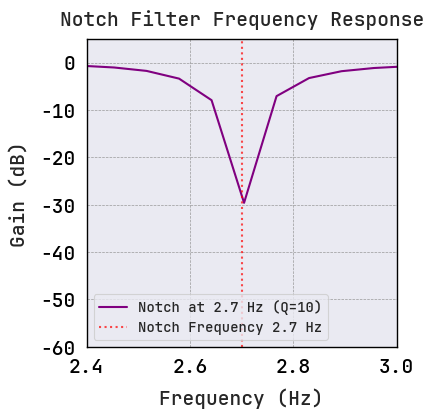

In [159]:
# NOTCH PLOT 

# Define the notch filter parameters
notch_freq = 2.7  # Notch frequency in Hz
Q = 10  # Quality factor

# Design the notch filter
b_notch, a_notch = signal.iirnotch(notch_freq, Q, fs)

# Define the frequency range for plotting the frequency response
freqs = np.linspace(0, 10, 1000)  # Linear spacing from 0 to 10 Hz

# Compute frequency response
w, h = signal.freqz(b_notch, a_notch, worN=2 * np.pi * freqs, fs=fs)

# Plot the notch filter response
plt.figure(figsize=(4, 4))  # Half the original size
plt.plot(w, 20 * np.log10(abs(h)), label=f'Notch at {notch_freq} Hz (Q={Q})', color='purple')

# Mark the notch frequency with a vertical line
plt.axvline(notch_freq, color='red', linestyle=':', alpha=0.7, label=f'Notch Frequency {notch_freq} Hz')

# Formatting the plot
plt.xlabel('Frequency (Hz)',fontsize=14)
plt.ylabel('Gain (dB)', fontsize=14)
plt.title('Notch Filter Frequency Response', fontsize=14, pad=10)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.ylim(-60, 5)
plt.xlim(2.4, 3)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend(fontsize=10)  # Smaller legend

plt.savefig('notch_filter.png')
plt.show()
